In [382]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
x = np.array([1])
y = np.array([-1])


In [383]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [384]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

In [385]:
def loss_function(h, g, x, x_, W):
    l1 = 0.5
    l2 = 0.5
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

In [386]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

In [387]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([cd, ca])
    
        
            

## Testing

In [388]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


### Currently the built-in families are:

   - Haar (haar)
   - Daubechies (db)
   - Symlets (sym)
   - Coiflets (coif)
   - Biorthogonal (bior)
   - Reverse biorthogonal (rbio)
   - “Discrete” FIR approximation of Meyer wavelet (dmey)
   - Gaussian wavelets (gaus)
   - Mexican hat wavelet (mexh)
   - Morlet wavelet (morl)
   - Complex Gaussian wavelets (cgau)
   - Shannon wavelets (shan)
   - Frequency B-Spline wavelets (fbsp)
   - Complex Morlet wavelets (cmor)


In [428]:
print(pywt.wavelist('haar'))

['haar']


In [429]:
w = 'haar'
wavelet = pywt.Wavelet(w)
print("is orthogonal?",wavelet.orthogonal)

is orthogonal? True


In [430]:
x = generate_signal(32, w)

In [431]:

model = Model(4)

In [432]:
model.fit(x, epochs=2000, learning_rate=0.001, good_error=1.5)

Epochs #1: 69.94544612856257 loss
Epochs #2: 66.62499213140953 loss
Epochs #3: 63.617507879631 loss
Epochs #4: 60.87575618068067 loss
Epochs #5: 58.353553771248755 loss
Epochs #6: 56.02377113372304 loss
Epochs #7: 53.862433966259466 loss
Epochs #8: 51.85026997155201 loss
Epochs #9: 49.971480101202744 loss
Epochs #10: 48.21288501253759 loss
Epochs #11: 46.563319987451706 loss
Epochs #12: 45.013198049937714 loss
Epochs #13: 43.55418920109885 loss
Epochs #14: 42.178981222272654 loss
Epochs #15: 40.881098677542276 loss
Epochs #16: 39.65476401983195 loss
Epochs #17: 38.49478953593582 loss
Epochs #18: 37.39649213925883 loss
Epochs #19: 36.357374605407045 loss
Epochs #20: 35.367275295511945 loss
Epochs #21: 34.427211177816844 loss
Epochs #22: 33.534007390258445 loss
Epochs #23: 32.6847493296765 loss
Epochs #24: 31.87675563899058 loss
Epochs #25: 31.10755485751698 loss
Epochs #26: 30.374865046161176 loss
Epochs #27: 29.67657586051224 loss
Epochs #28: 29.010732666906453 loss
Epochs #29: 28.3755

Epochs #245: 8.985644399998646 loss
Epochs #246: 8.959010971509757 loss
Epochs #247: 8.933480310725203 loss
Epochs #248: 8.907036352334957 loss
Epochs #249: 8.880675554087489 loss
Epochs #250: 8.854397796232343 loss
Epochs #251: 8.828202950231532 loss
Epochs #252: 8.802293992353977 loss
Epochs #253: 8.777080994528939 loss
Epochs #254: 8.75115661764996 loss
Epochs #255: 8.725313738744685 loss
Epochs #256: 8.699552209595398 loss
Epochs #257: 8.673871874309807 loss
Epochs #258: 8.648577897007662 loss
Epochs #259: 8.623770375210995 loss
Epochs #260: 8.598354784558852 loss
Epochs #261: 8.573018895964038 loss
Epochs #262: 8.547762538460633 loss
Epochs #263: 8.522585534409094 loss
Epochs #264: 8.497802038127531 loss
Epochs #265: 8.473481252991405 loss
Epochs #266: 8.448562948893066 loss
Epochs #267: 8.423722449627006 loss
Epochs #268: 8.398959566494758 loss
Epochs #269: 8.374274105034177 loss
Epochs #270: 8.349901868447757 loss
Epochs #271: 8.326142647560776 loss
Epochs #272: 8.30170961295700

Epochs #485: 4.432674869345759 loss
Epochs #486: 4.4186702119276635 loss
Epochs #487: 4.404734531408899 loss
Epochs #488: 4.3912930051479995 loss
Epochs #489: 4.3773795035367185 loss
Epochs #490: 4.363489476373486 loss
Epochs #491: 4.3496228790473 loss
Epochs #492: 4.335779666248524 loss
Epochs #493: 4.321959791948736 loss
Epochs #494: 4.30848049411453 loss
Epochs #495: 4.294929397449904 loss
Epochs #496: 4.28119817643748 loss
Epochs #497: 4.267489559466687 loss
Epochs #498: 4.253803507017251 loss
Epochs #499: 4.240139978836124 loss
Epochs #500: 4.226529835096787 loss
Epochs #501: 4.2134038480144 loss
Epochs #502: 4.199826571543038 loss
Epochs #503: 4.18627111128438 loss
Epochs #504: 4.172737433156722 loss
Epochs #505: 4.159225502350301 loss
Epochs #506: 4.145735283293151 loss
Epochs #507: 4.132675348806745 loss
Epochs #508: 4.119322747599926 loss
Epochs #509: 4.105916523377535 loss
Epochs #510: 4.0925313161222565 loss
Epochs #511: 4.07916709648056 loss
Epochs #512: 4.065823834331659 l

Epochs #729: 1.8982709858794282 loss
Epochs #730: 1.8920946559495144 loss
Epochs #731: 1.8891070169400115 loss
Epochs #732: 1.8809027220253256 loss
Epochs #733: 1.8764351114618754 loss
Epochs #734: 1.8695282284034433 loss
Epochs #735: 1.8638024402882358 loss
Epochs #736: 1.858196502655373 loss
Epochs #737: 1.8512087099012335 loss
Epochs #738: 1.8469072088388763 loss
Epochs #739: 1.8386536400496958 loss
Epochs #740: 1.8356600256442432 loss
Epochs #741: 1.8261369627515252 loss
Epochs #742: 1.824454645334992 loss
Epochs #743: 1.8142242767065297 loss
Epochs #744: 1.8093185420845064 loss
Epochs #745: 1.802753309724017 loss
Epochs #746: 1.7980517280953345 loss
Epochs #747: 1.7942690420950853 loss
Epochs #748: 1.7857784120309688 loss
Epochs #749: 1.78051036901723 loss
Epochs #750: 1.773582535852986 loss
Epochs #751: 1.7693501296040621 loss
Epochs #752: 1.7614249662194699 loss
Epochs #753: 1.7582282060949765 loss
Epochs #754: 1.74989432177826 loss
Epochs #755: 1.7472122784755886 loss
Epochs #7

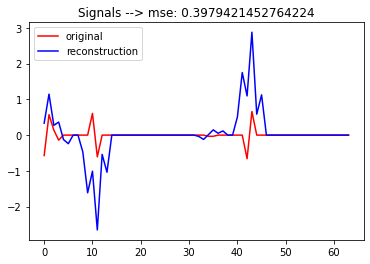

In [433]:
p = model.predict(x)
mse = mean_squared_error(p,x)

plt.plot(np.arange(len(x)), x, c = 'r', label="original")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()
plt.title("Signals -->" + " mse: " + str(mse))
print()

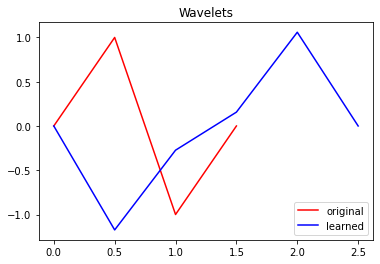

In [434]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet(w).wavefun(level=1)
lo = np.arange(len(ao))
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets")
plt.legend()
print()

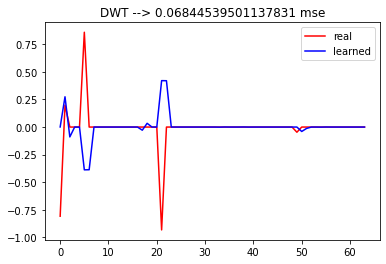

In [435]:

fake_dwt = model.dwt(x)
ca, cd = pywt.dwt(x, wavelet=w)
real_dwt = np.concatenate([cd, ca])

fake_len = len(fake_dwt)
real_len = len(real_dwt)

min_len = min(fake_len, real_len)
real_dwt = real_dwt[:min_len]
fake_dwt = fake_dwt[:min_len]

mse_dwt = mean_squared_error(real_dwt, fake_dwt)
plt.plot(np.arange(min_len), real_dwt, c = 'r', label = 'real')
plt.plot(np.arange(min_len), fake_dwt, c = 'b', label = 'learned')
plt.title("DWT --> " + str(mse_dwt) + " mse")
plt.legend()
print()